# Flash Model for [R32][emim_TF2N]
### Gabriela Franco
### 03/10/21

In [1]:
# import functions
import idaes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom
# import HFC_IL mixture properties
from HFC32_emimTf2N_PR import configuration

# Read data
data = pd.read_csv('R32_emimTf2N.csv')
data_283= data[0:7]
print(data_283)

   temperature  pressure  x_R32  x_emimTf2N
0       283.15     10200  0.014       0.986
1       283.15    100100  0.136       0.864
2       283.15    250300  0.306       0.694
3       283.15    399300  0.448       0.552
4       283.15    549300  0.570       0.430
5       283.15    700400  0.672       0.328
6       283.15    849400  0.786       0.214


## Run Parameter Estimation Function

**T = 298.15 K**

In [ ]:
#run parameter estimation function

# T= 298.15 k
from binary_param import binary_params_peng
from HFC32_emimTf2N_PR import configuration
binary_params_peng('R32_emimTf2N.csv', configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
    init_temp = 298.15, init_press = 250200, init_x_c1 = 0.218, init_x_c2 =0.782 ,
    init_kappa_2_1 = 0.025, init_kappa_1_2 = -0.03, eps = 0.1, scaling_fac = 1e-4)

kappa1= -0.05619426266499274
kappa2= -0.20093139701830412
# print('PR_kappa[R32,emimTf2N] = ', kappa1)
# print('PR_kappa[emimTf2N,R32] = ', kappa2)


**T = 283.15 K**

In [ ]:
#run parameter estimation function
# T= 283.15 K
from binary_param import binary_params_peng
from HFC32_emimTf2N_PR import configuration
binary_params_peng('R32_emimTf2N.csv', configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
    init_temp = 283.15, init_press =  250300, init_x_c1 = 0.306, init_x_c2 = 0.694 ,
    init_kappa_2_1 = 0.025, init_kappa_1_2 = -0.03, eps = 0.1, scaling_fac = 1e-4)

# kappa1= -0.05619426266499274
# kappa2= -0.20093139701830412
# print('PR_kappa[R32,emimTf2N] = ', kappa1)
# print('PR_kappa[emimTf2N,R32] = ', kappa2)

## Create Flash Model

In [2]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

2021-03-14 18:24:24 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
The initial DOF is 7


**T=283.15 K**

In [3]:
# initialize arrays for x and P
R32_x = np.zeros((len(data_283)))
P = np.zeros((len(data_283)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_283)):
    m.fs.liq = data_283["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.flow_mol.fix(1) 
    m.fs.F101.inlet.temperature.fix(float(data_283["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_283["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_283["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_283["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_283["temperature"].iloc[i]))
    m.fs.properties.PR_kappa['emimTf2N', 'R32'].fix(-0.01419)
    m.fs.properties.PR_kappa['R32', 'emimTf2N'].fix(-0.01810)
    
    DOF_final = degrees_of_freedom(m)
    print("The final DOF is {0}".format(DOF_final))

    # solver
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    solver = SolverFactory('ipopt')
    solver.options = {'tol': 1e-6}
    status = solver.solve(m, tee = False)
#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])
    else:
        print('Infeasible.')

The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0


In [4]:
print(P)
print(data_283["pressure"])
# print(R32_x_283)
# print(data_283["x_R32"])

[ 12598.0055637  125024.61392388 290613.81031734 438553.02826632
 574172.42446826 694552.48200121 836831.75396979]
0     10200
1    100100
2    250300
3    399300
4    549300
5    700400
6    849400
Name: pressure, dtype: int64


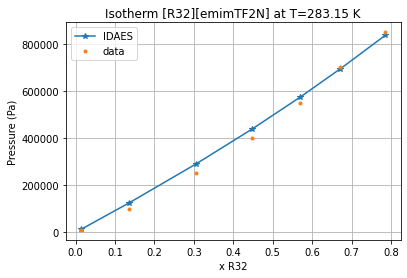

In [5]:
plt.plot(R32_x,P,"-*",label="IDAES")  
plt.plot(data_283["x_R32"],data_283["pressure"],".",label="data")  
plt.title('Isotherm [R32][emimTF2N] at T=283.15 K')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.legend()
plt.show()

## Sensitivity Analysis

**T= 298.15K**

In [6]:
# Read data
data = pd.read_csv('R32_emimTf2N.csv')
data_283= data[0:7]
data_298 = data[7:15]
data_323 = data[15:23]
data_348 = data[23:31]
print(len(data_298))
print(data_298)

8
    temperature  pressure  x_R32  x_emimTf2N
7        298.15      9600  0.010       0.990
8        298.15     99800  0.095       0.905
9        298.15    250200  0.218       0.782
10       298.15    399400  0.325       0.675
11       298.15    549400  0.417       0.583
12       298.15    699500  0.499       0.501
13       298.15    849500  0.570       0.430
14       298.15    999700  0.643       0.357


**Change kappa values manually and see behavior**

In [7]:
# initialize arrays for x and P
R32_x = np.zeros((len(data_298)))
P = np.zeros((len(data_298)))

def calc_outlet_xP(k21,k12):
    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(data_298)):
        m.fs.liq = data_298["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.flow_mol.fix(1) 
        m.fs.F101.inlet.temperature.fix(float(data_298["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data_298["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_298["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_298["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data_298["temperature"].iloc[i]))
        m.fs.properties.PR_kappa['emimTf2N', 'R32'].fix(k21) # (-0.20093)
        m.fs.properties.PR_kappa['R32', 'emimTf2N'].fix(k12) # (-0.05619)

#         DOF_final = degrees_of_freedom(m)
#         print("The final DOF is {0}".format(DOF_final))

        # solver
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        solver = SolverFactory('ipopt')
        solver.options = {'tol': 1e-6}
        status = solver.solve(m, tee = False)
    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible.')
    return(R32_x,P)

In [8]:
# try plotting kappas manually -

kappa21= np.array([-0.200,-0.30,-0.40,-0.50])
kappa12= np.array([-0.056,-0.066,-0.076,-0.086])

x1,P1= calc_outlet_xP(kappa21[0],kappa12[0])
x2,P2= calc_outlet_xP(kappa21[0],kappa12[1])
x3,P3= calc_outlet_xP(kappa21[0],kappa12[2])
x4,P4= calc_outlet_xP(kappa21[0],kappa12[3])
x5,P5= calc_outlet_xP(kappa21[1],kappa12[0])
x6,P6= calc_outlet_xP(kappa21[1],kappa12[1])
x7,P7= calc_outlet_xP(kappa21[1],kappa12[2])
x8,P8= calc_outlet_xP(kappa21[1],kappa12[3])
x9,P9= calc_outlet_xP(kappa21[2],kappa12[0])
x10,P10= calc_outlet_xP(kappa21[2],kappa12[1])
x11,P11= calc_outlet_xP(kappa21[2],kappa12[2])
x12,P12= calc_outlet_xP(kappa21[2],kappa12[3])



    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usual

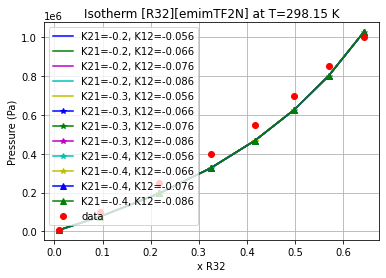

In [9]:
# plot lines
plt.plot(x1,P1,"b-",label="K21=-0.2, K12=-0.056")
plt.plot(x2,P2,"g-",label="K21=-0.2, K12=-0.066")
plt.plot(x3,P3,"m-",label="K21=-0.2, K12=-0.076")
plt.plot(x4,P4,"c-",label="K21=-0.2, K12=-0.086")
plt.plot(x5,P5,"y-",label="K21=-0.3, K12=-0.056")
plt.plot(x6,P6,"b*-",label="K21=-0.3, K12=-0.066")
plt.plot(x7,P7,"g*-",label="K21=-0.3, K12=-0.076")
plt.plot(x8,P8,"m*-",label="K21=-0.3, K12=-0.086")
plt.plot(x9,P9,"c*-",label="K21=-0.4, K12=-0.056")
plt.plot(x10,P10,"y*-",label="K21=-0.4, K12=-0.066")
plt.plot(x11,P11,"b^-",label="K21=-0.4, K12=-0.076")
plt.plot(x12,P12,"g^-",label="K21=-0.4, K12=-0.086")

# plot data and configuration
plt.plot(data_298["x_R32"],data_298["pressure"],"ro",label="data")  
plt.title('Isotherm [R32][emimTF2N] at T=298.15 K')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.legend()
plt.show()



In [10]:
# plot function to see if it works
def plot_sens_analysis(kappa21,kappa12):
    x1,P1= calc_outlet_xP(kappa21[0],kappa12[0])
    plt.plot(x1,P1,"b-",label="K21=-0.2, K12=-0.056")
    x2,P2= calc_outlet_xP(kappa21[0],kappa12[1])
    plt.plot(x2,P2,"g-",label="K21=-0.2, K12=-0.066")
    x3,P3= calc_outlet_xP(kappa21[0],kappa12[2])
    plt.plot(x3,P3,"m-",label="K21=-0.2, K12=-0.076")
    x4,P4= calc_outlet_xP(kappa21[0],kappa12[3])
    plt.plot(x4,P4,"c-",label="K21=-0.2, K12=-0.086")
    x5,P5= calc_outlet_xP(kappa21[1],kappa12[0])
    plt.plot(x5,P5,"b*-",label="K21=-0.3, K12=-0.056")
    x6,P6= calc_outlet_xP(kappa21[1],kappa12[1])
    plt.plot(x6,P6,"g*-",label="K21=-0.3, K12=-0.066")
    x7,P7= calc_outlet_xP(kappa21[1],kappa12[2])
    plt.plot(x7,P7,"m*-",label="K21=-0.3, K12=-0.076")
    x8,P8= calc_outlet_xP(kappa21[1],kappa12[3])
    plt.plot(x8,P8,"c*-",label="K21=-0.3, K12=-0.086")
    x9,P9= calc_outlet_xP(kappa21[2],kappa12[0])
    plt.plot(x9,P9,"b^-",label="K21=-0.4, K12=-0.056")
    x10,P10= calc_outlet_xP(kappa21[2],kappa12[1])
    plt.plot(x10,P10,"g^-",label="K21=-0.4, K12=-0.066")
    x11,P11= calc_outlet_xP(kappa21[2],kappa12[2])
    plt.plot(x11,P11,"m^-",label="K21=-0.4, K12=-0.076")
    x12,P12= calc_outlet_xP(kappa21[2],kappa12[3])
    plt.plot(x12,P12,"c^-",label="K21=-0.4, K12=-0.086")
    # plot data and configuration
    plt.plot(data_298["x_R32"],data_298["pressure"],"ro",label="data")  
    plt.title('Isotherm [R32][emimTF2N] at T=298.15 K')
    plt.ylabel('Pressure (Pa)')
    plt.xlabel('x R32')
    plt.grid(True)
    plt.legend()
    plt.show()

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usual

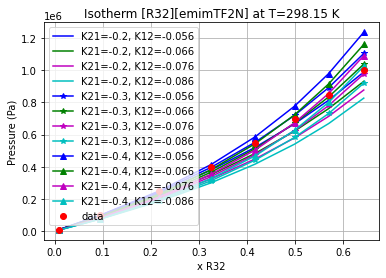

In [11]:
kappa21= np.array([-0.200,-0.30,-0.40,-0.5])
kappa12= np.array([-0.056,-0.066,-0.076,-0.086])
plot_sens_analysis(kappa21,kappa12)

**Try a nested for loop**

In [ ]:
# initialize arrays for x and P
k_21 = np.array([-0.20,-0.50,-0.7])
k_12 = np.array([-0.07,-0.50,-0.03])
# print(k21)
# print(k12)
R32_x = np.zeros((len(data_298)))
P = np.zeros((len(k_21),len(k_12),len(data_298)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i  in range(len(k_21)): # 10 kappas
    m.fs.properties.PR_kappa['emimTf2N', 'R32'].fix(k_21[i])
    
    for j  in range(len(k_12)): # 10 kappas
        m.fs.properties.PR_kappa['R32', 'emimTf2N'].fix(k_12[j])
        
        for k in range(len(data_298)): # length of data array (10 rows (10 kappas), 8 columns (8 mol frac/pressure))
            m.fs.liq = data_298["x_emimTf2N"].iloc[k]
            m.fs.F101.inlet.flow_mol.fix(1) 
            m.fs.F101.inlet.temperature.fix(float(data_298["temperature"].iloc[k]))
            m.fs.F101.inlet.pressure.fix(float(data_298["pressure"].iloc[k]))
            m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_298["x_R32"].iloc[k])+0.1)
            m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_298["x_R32"].iloc[k]+0.1)))
            m.fs.F101.vap_outlet.temperature.fix(float(data_298["temperature"].iloc[k]))

            DOF_final = degrees_of_freedom(m)
            print("The final DOF is {0}".format(DOF_final))

            try: # solver
                m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
                solver = SolverFactory('ipopt')
                solver.options = {'tol': 1e-6}
                status = solver.solve(m, tee = False)
                if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
                    R32_x[k] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
                    P[i,j,k] = value(m.fs.F101.vap_outlet.pressure[0])
                else:
                    print('Infeasible.')
                    P[i,j,k] = 0
            except ValueError:
                P[i,j,k] = 0
                